In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
# Load (preprocessed) data
# 
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables 
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [4]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [5]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    print(idx, feature)
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

5 education
6 marital_status
7 partner_education
8 gender
9 house
10 income
11 msa
12 rent
13 political
14 religion
15 work
16 gender_older
17 education_difference


/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [7]:
# Set up the model and GridSearch for random forest hyperparameter tuning
param_grid = [{'n_estimators': [20, 50, 100, 120, 150],
               'max_features': [12, 16, 20, 25],
               'min_samples_split': [12, 14, 16, 18, 20],
               'max_depth': [3, 4, 5, 6, 8, 15, 20]}]

rf = RandomForestClassifier(class_weight='balanced')
rf = ExtraTreesClassifier(class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=7, scoring='roc_auc', n_jobs = -1)

# Extend the preprocessing pipeline to include random forest and grid search
pipeline = make_pipeline(preprocessing_pipeline, grid_search)

# Fit the model and tune the hyperparameters
pipeline.fit(train, labels_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous_pipeline', Pipeline(memory=None,
     steps=[('selector', DataSelector(attribute_indices=[0, 1, 2, 3, 4])), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('categorical_pipeline', Pipeline(...pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0))])

In [8]:
# Hyperparameters found by GridSearchCV
bests = (pipeline.named_steps['gridsearchcv'].best_params_)
print(bests)

{'max_depth': 4, 'max_features': 25, 'min_samples_split': 14, 'n_estimators': 100}


In [9]:
# Evalute random forest classifier on training data (it overfits, small sample size)
y_predict = pipeline.predict(train)
f1 = f1_score(labels_train, y_predict)
print('F1 on train:', f1)

# Evalute random forest classifier on train data
y_predict = pipeline.predict(train)
auc = roc_auc_score(labels_train, y_predict)
print('AUC on train:', auc)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
f1 = f1_score(labels_test, y_predict)
print('F1 on test:', f1)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
auc = roc_auc_score(labels_test, y_predict)
print('AUC on test:', auc)

F1 on train: 0.840395480226
AUC on train: 0.818894687542
F1 on test: 0.851612903226
AUC on test: 0.798517520216


0.7601809954751131


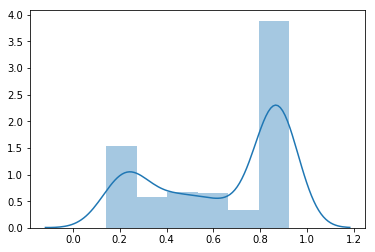

In [10]:
import seaborn as sns
%matplotlib inline

print(labels_test.mean())

sns.distplot(pipeline.predict_proba(test)[:,1])

In [11]:
# Get feature importances of random forest model ("global interpretability")
best_estimator = pipeline.named_steps['gridsearchcv'].best_estimator_

importances = best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_names = data.columns
for f in range(data.shape[1]):
    print("%2d. feature %s (%f)" %
          (f + 1, feature_names[f], importances[indices[f]]))

Feature ranking:
 1. feature age (0.533907)
 2. feature partner_age (0.177178)
 3. feature age_diff_abs (0.071634)
 4. feature children (0.052524)
 5. feature visits_relatives (0.018451)
 6. feature education (0.011038)
 7. feature marital_status (0.010937)
 8. feature partner_education (0.009516)
 9. feature gender (0.008681)
10. feature house (0.008554)
11. feature income (0.008330)
12. feature msa (0.008062)
13. feature rent (0.005590)
14. feature political (0.005169)
15. feature religion (0.004582)
16. feature work (0.004117)
17. feature gender_older (0.003814)
18. feature education_difference (0.003612)


In [12]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

Couples probability of staying together: 0.800438736057


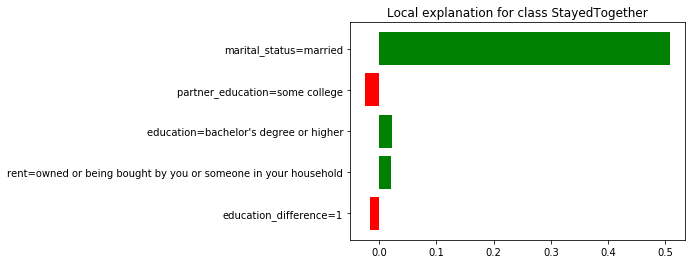

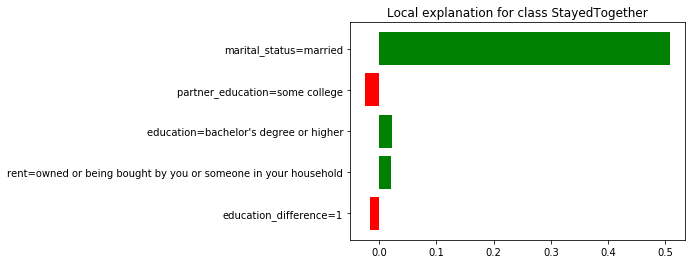

In [13]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.455291055188


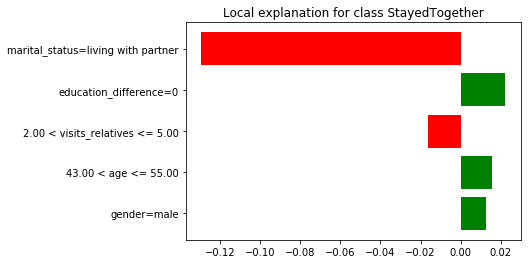

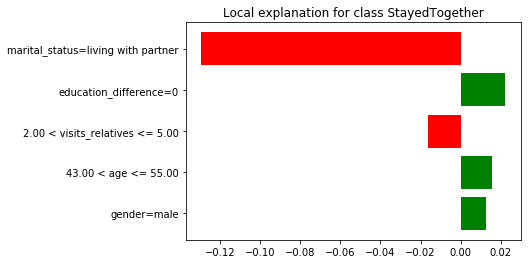

In [14]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [15]:
# and we see differences in explaining the model's predictions.

Couples probability of staying together: 0.55796197707


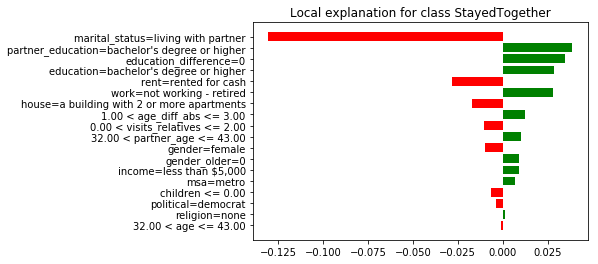

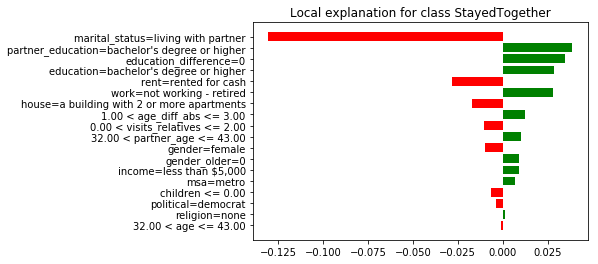

In [16]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=20)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.55796197707


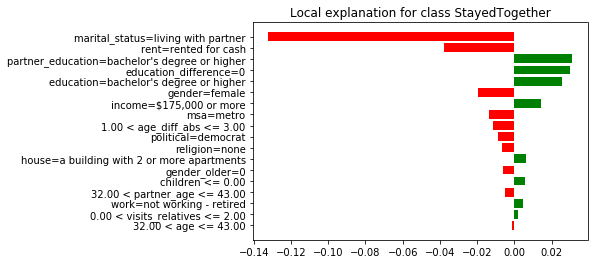

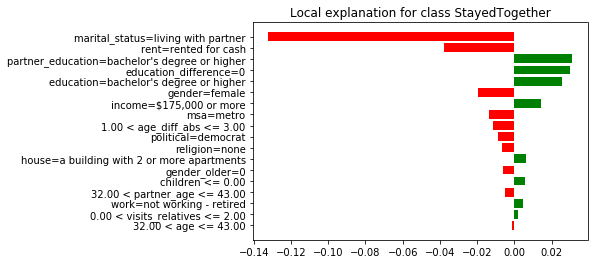

In [17]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=20)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.628444289958


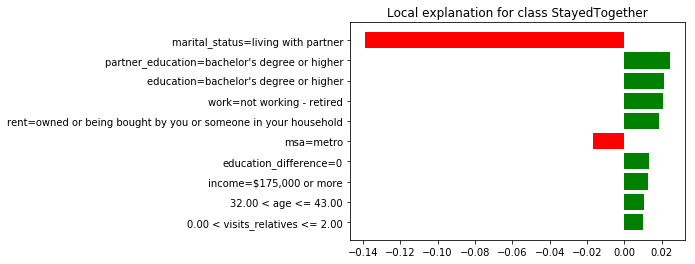

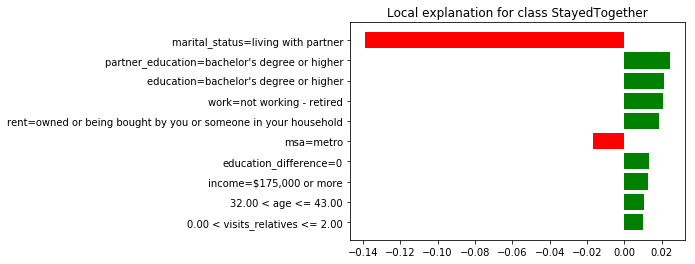

In [18]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.86487103547


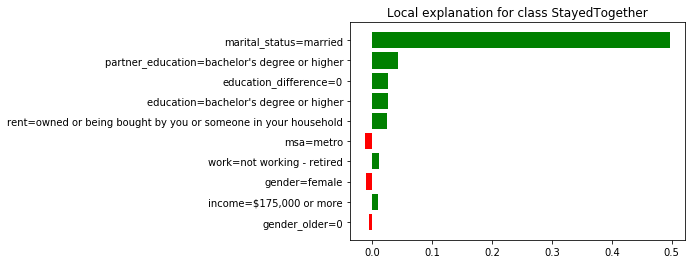

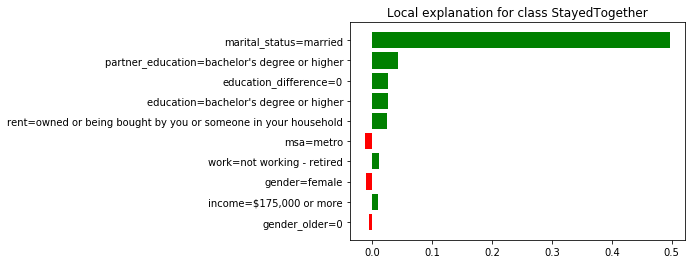

In [19]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [20]:
import eli5

In [21]:
eli5.explain_weights(best_estimator)

Weight,Feature
0.5339 ± 0.4966,x11
0.1772 ± 0.3981,x12
0.0716 ± 0.2004,x9
0.0525 ± 0.1055,x10
0.0185 ± 0.0614,x15
0.0110 ± 0.0652,x1
0.0109 ± 0.0247,x74
0.0095 ± 0.0493,x47
0.0087 ± 0.0185,x8
0.0086 ± 0.0461,x21


In [22]:
eli5.explain_prediction(best_estimator, preprocessing_pipeline.transform(test)[example])

Explanation(estimator="ExtraTreesClassifier(bootstrap=False, class_weight='balanced',\n           criterion='gini', max_depth=4, max_features=25,\n           max_leaf_nodes=None, min_impurity_decrease=0.0,\n           min_impurity_split=None, min_samples_leaf=1,\n           min_samples_split=14, min_weight_fraction_leaf=0.0,\n           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,\n           verbose=0, warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.49999999999999517, std=None, value=1.0), FeatureWeight(feature='x11', weight=0.20699134966600227, std=None, value=0.0), FeatureWeight(feature='x15', weight=0.029654880779120874, std=None, value=0.0), FeatureWeight(feature='x5', weight=0.013177514816861333, std=None, value=0.0), FeatureWeight(feature='x6', weight=0.0053724706719937079, std=None, value=1.0), FeatureWeight(feature='x69', weight=0.0015349993157068365, std=None, value=0.0), FeatureWeight(feature='x28', weight=0.0012300707801521694, std=None, value=0.0), FeatureWeight(feature='x41', weight=0.001033173358366214, std=None, value=0.0), FeatureWeight(feature='x51', weight=0.00096437153902416254, std=None, value=0.0), FeatureWeight(feature='x3', weight=0.00080119639425432212, std=None, value=-0.526104043390627), FeatureWeight(feature='x71', weight=0.00049958006961333572, std=None, value=0.0), FeatureWeight(feature='x60', weight=0.00047388802156876907, std=None, value=0.0), FeatureWeight(feature='x44', weight=0.00019928912174025038, std=None, value=1.0), FeatureWeight(feature='x50', weight=6.4299167947213796e-05, std=None, value=0.0)], neg=[FeatureWeight(feature='x10', weight=-0.071647028672233465, std=None, value=1.0), FeatureWeight(feature='x12', weight=-0.070985987153133742, std=None, value=0.0), FeatureWeight(feature='x9', weight=-0.02906223220644364, std=None, value=0.0), FeatureWeight(feature='x74', weight=-0.013936735107191964, std=None, value=1.0), FeatureWeight(feature='x47', weight=-0.0058771512818428032, std=None, value=1.0), FeatureWeight(feature='x52', weight=-0.0058109392067192235, std=None, value=0.0), FeatureWeight(feature='x1', weight=-0.0047416866320970528, std=None, value=0.28399519490578728), FeatureWeight(feature='x48', weight=-0.0036188529216592603, std=None, value=0.0), FeatureWeight(feature='x0', weight=-0.003236114601806742, std=None, value=0.13203233670019812), FeatureWeight(feature='x21', weight=-0.0030924421783282614, std=None, value=0.0), FeatureWeight(feature='x18', weight=-0.0027440624321647413, std=None, value=0.0), FeatureWeight(feature='x14', weight=-0.00059969872101593995, std=None, value=0.0), FeatureWeight(feature='x24', weight=-0.00038929532618171283, std=None, value=1.0), FeatureWeight(feature='x8', weight=-0.0003757771771310037, std